# Model Explainability with SHAP

**Objective:**  
Interpret the best fraud detection model using SHAP to understand:
- Which features drive fraud predictions globally
- Why individual transactions are flagged or missed
- How insights translate into actionable business rules


In [1]:
import shap
import fraud_detection.explainability.feature_importance as fi
import fraud_detection.explainability.predictions as pr
import fraud_detection.explainability.shap_explainer as shae
import fraud_detection.viz.importance_plots as viz
from fraud_detection.data.loader import DataHandler
from fraud_detection.core.settings import settings

d:\10Acadamy\Week 5&6\Tasks\fraud-detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = DataHandler.from_registry(
    section="MODELS",
    path_key="e_models_dir",
    filename="xgboost_best_model.pkl"
).load()

In [3]:
# Test_original Data
test_original = DataHandler.from_registry(
    "DATA", "processed_dir", "test_original.parquet").load()

# Train_original Data
train_original = DataHandler.from_registry(
    "DATA", "processed_dir", "train_original.parquet").load()


In [4]:
FEATURES = settings.get("features")

TARGET = FEATURES["target"]


X_train_orig = train_original.drop(columns=[TARGET])
y_train_orig = train_original[TARGET]


X_test = test_original.drop(columns=[TARGET])
y_test = test_original[TARGET]

In [5]:
builtin_fi = fi.get_builtin_feature_importance(
    model=model,
    feature_names=X_train_orig.columns.tolist(),
    top_n=10,
)

builtin_fi

,feature,importance
0,device_id_count,0.294202
1,country_United States,0.076097
2,day_of_week,0.057955
3,ip_address_count,0.048109
4,country_Unknown,0.046393
5,time_since_signup,0.032869
6,country_China,0.029689
7,country_Japan,0.020054
8,browser_Opera,0.018205
9,country_United Kingdom,0.017840


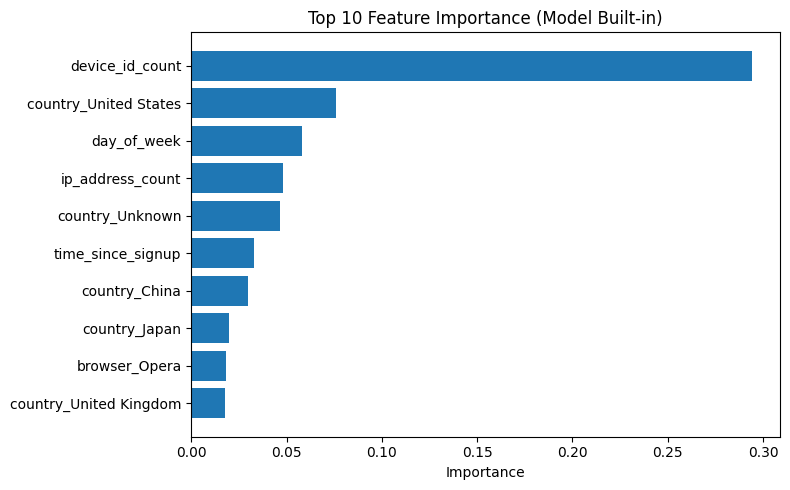

In [6]:
viz.plot_feature_importance(
    df=builtin_fi,
    title="Top 10 Feature Importance (Model Built-in)",
    top_n=10,
)

In [7]:
shap_values, explainer = shae.compute_shap_values(
    model=model,
    X=X_train_orig,
)

In [8]:
shap_fi = shae.get_shap_importance(
    X=X_train_orig,
    shap_values=shap_values,
    top_n=10,
)

shap_fi

,feature,shap_importance
0,device_id_count,1.388079
1,time_since_signup,0.510918
2,day_of_week,0.428988
3,country_United States,0.158557
4,hour_of_day,0.157371
5,age,0.144513
6,ip_address_count,0.125475
7,sex_M,0.109175
8,sex_F,0.085717
9,country_Unknown,0.077443


###  Global behavior- SHAP Summary Plots

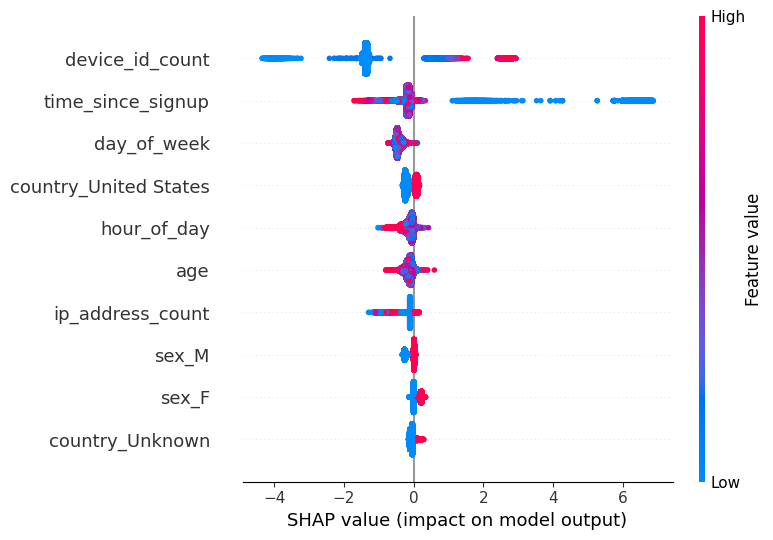

In [9]:
shap.summary_plot(
    shap_values,
    X_train_orig,
    max_display=10,
)

In [10]:
y_proba = model.predict_proba(X_test)[:, 1]

results_df = pr.build_prediction_frame(
    X=X_test,
    y_true=y_test,
    y_proba=y_proba,
    threshold=0.5,
)

results_df.head()

,purchase_value,age,time_since_signup,hour_of_day,day_of_week,tx_count_uder_id_1h,tx_count_uder_id_24h,device_id_count,ip_address_count,user_total_transactions,...,country_United States,country_Unknown,country_Uruguay,country_Uzbekistan,country_Venezuela,country_Viet Nam,country_infrequent_sklearn,y_true,y_pred,y_proba
0,2.402642,4.407148,3.089637,1.447911,0.996208,1.0,1.0,0.382038,0.385054,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0.054566
1,2.511853,4.291170,3.269861,0.723956,1.992416,1.0,1.0,0.382038,0.385054,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.030137
2,1.747376,4.175193,1.645686,2.606240,0.498104,1.0,1.0,0.764076,0.385054,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0.291608
3,1.365138,2.899439,2.012097,1.592702,0.000000,1.0,1.0,0.382038,0.385054,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.059495
4,2.675670,4.871058,3.129238,1.592702,0.498104,1.0,1.0,0.382038,0.385054,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.063916


In [11]:
cases = pr.sample_error_cases(results_df)

cases.keys()

dict_keys(['true_positive', 'false_positive', 'false_negative'])

### Force plot

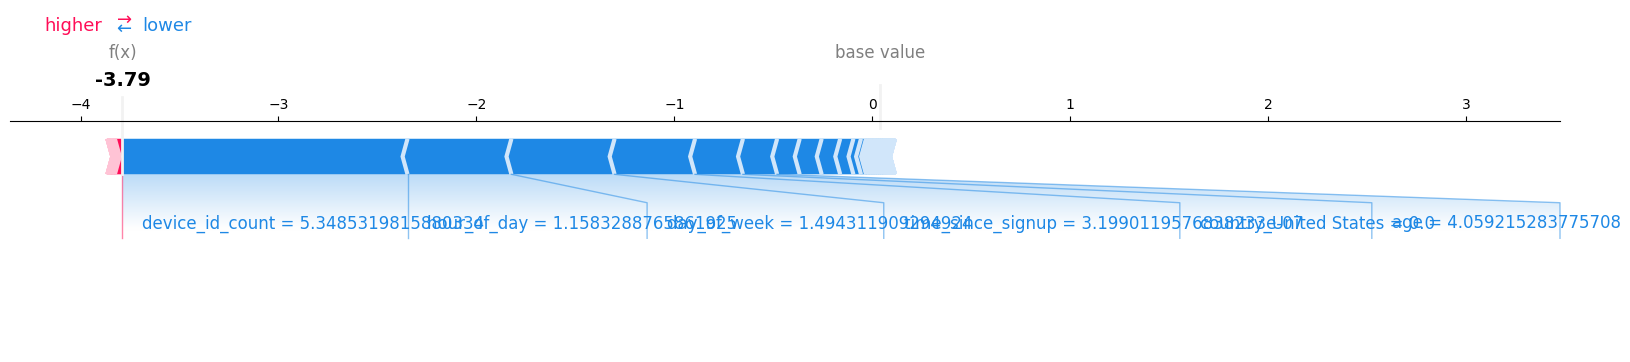

In [12]:
tp = cases["true_positive"]
viz.plot_single_prediction_force(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
)

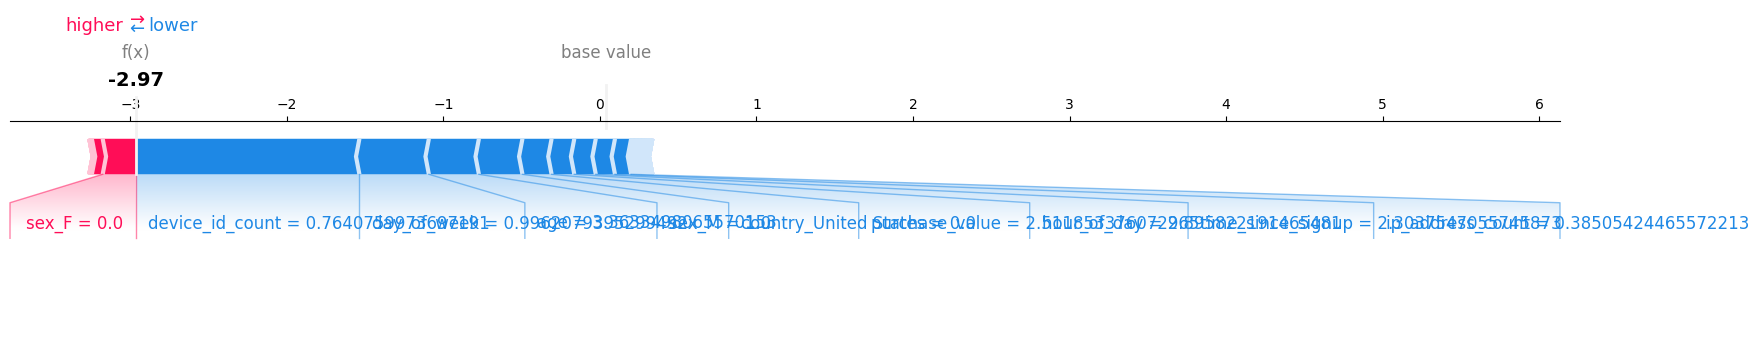

In [13]:
tp = cases["false_positive"]
viz.plot_single_prediction_force(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,

)

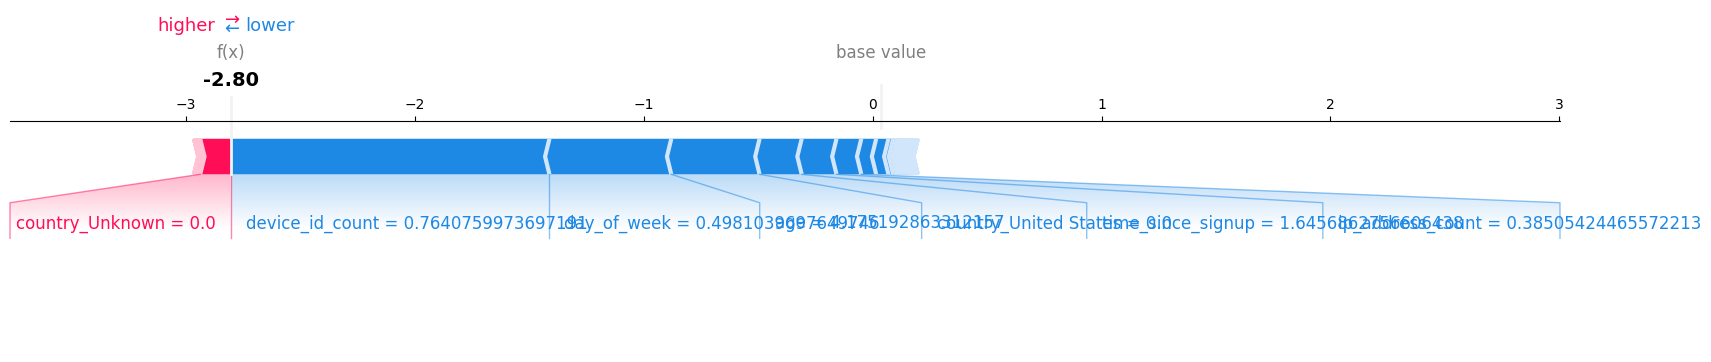

In [14]:
tp = cases["false_negative"]
viz.plot_single_prediction_force(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
)

### Single prediction - waterfall plot

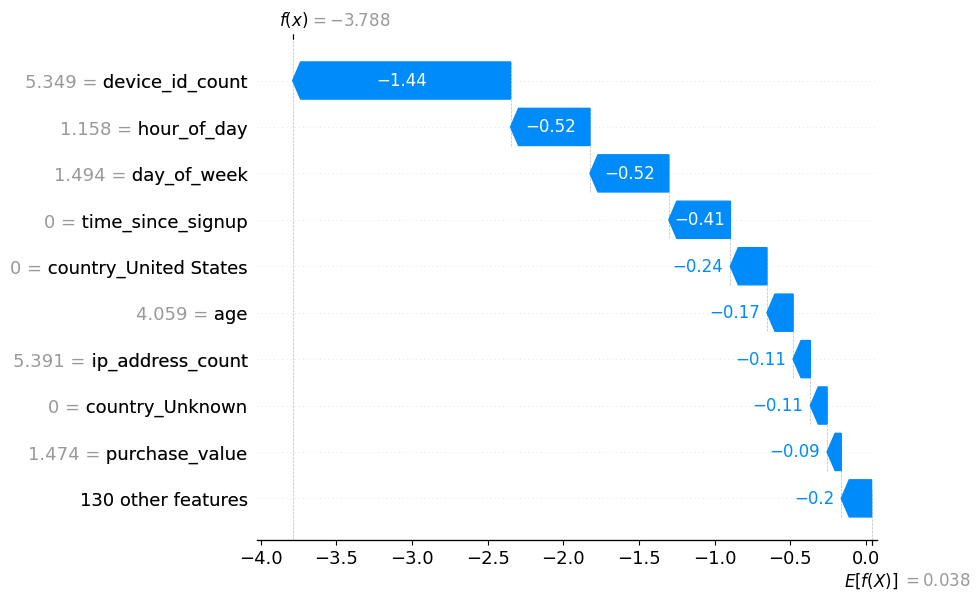

In [16]:
tp = cases["true_positive"]

viz.plot_shap_waterfall(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    max_display=10,
)

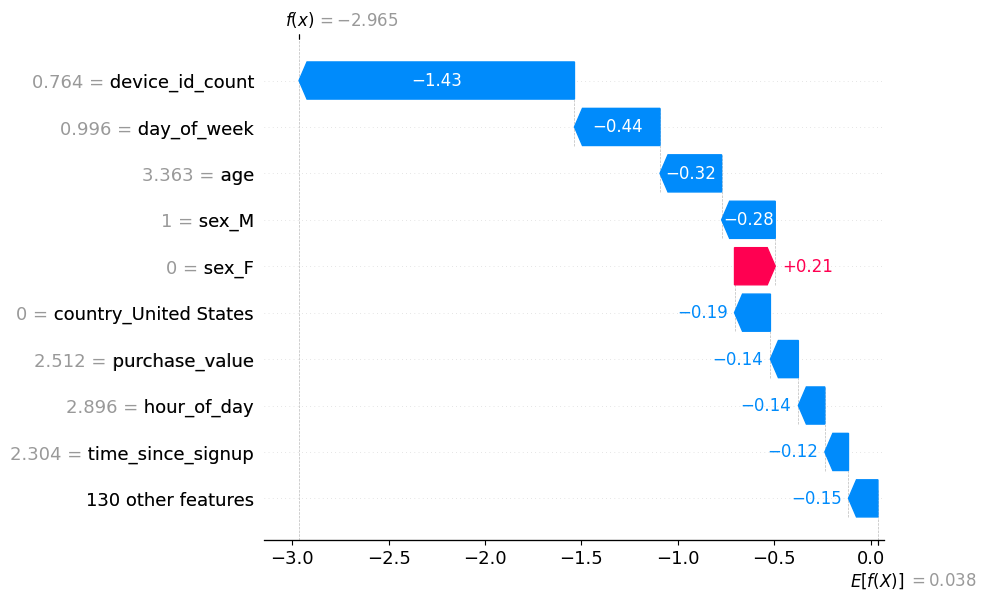

In [17]:
tp = cases["false_positive"]

viz.plot_shap_waterfall(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    max_display=10,
)

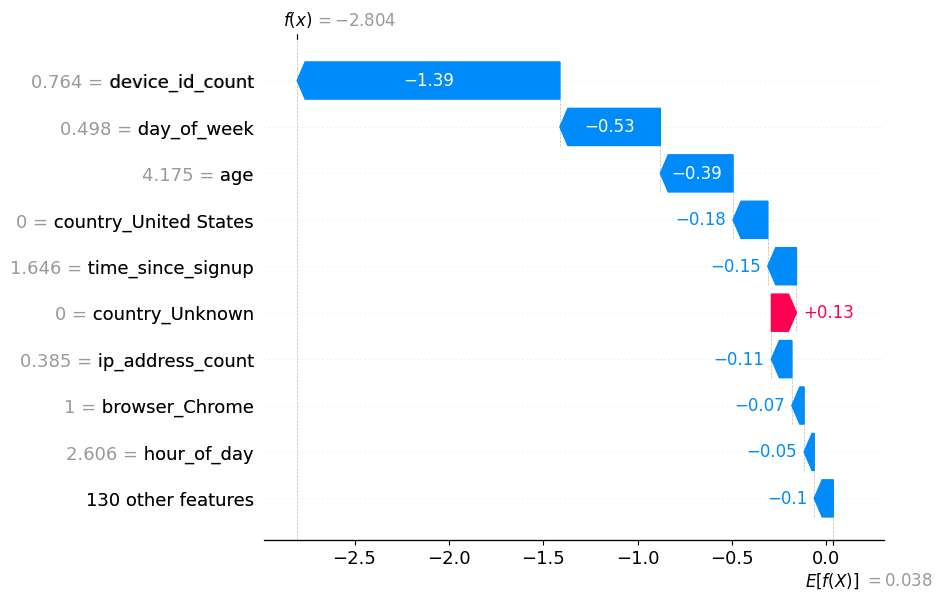

In [18]:
tp = cases["false_negative"]

viz.plot_shap_waterfall(
    explainer=explainer,
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    max_display=10,
)


# Single prediction bar plot

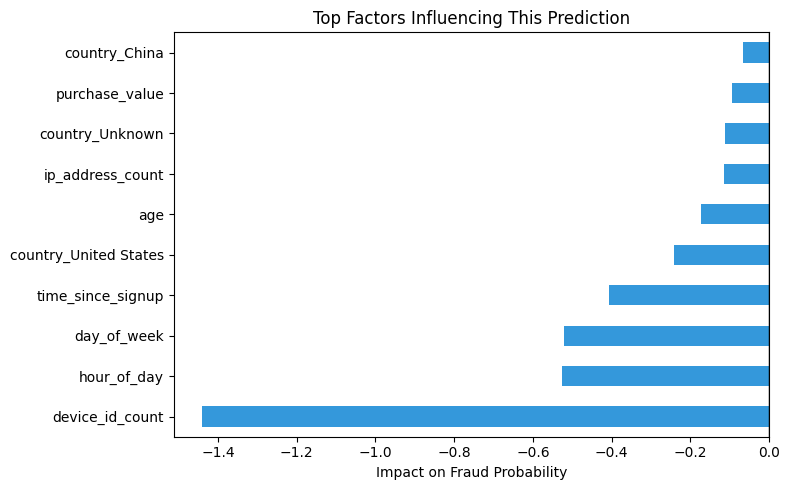

In [19]:
tp = cases["true_positive"]

viz.plot_single_prediction_bar(
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    top_n=10,
)


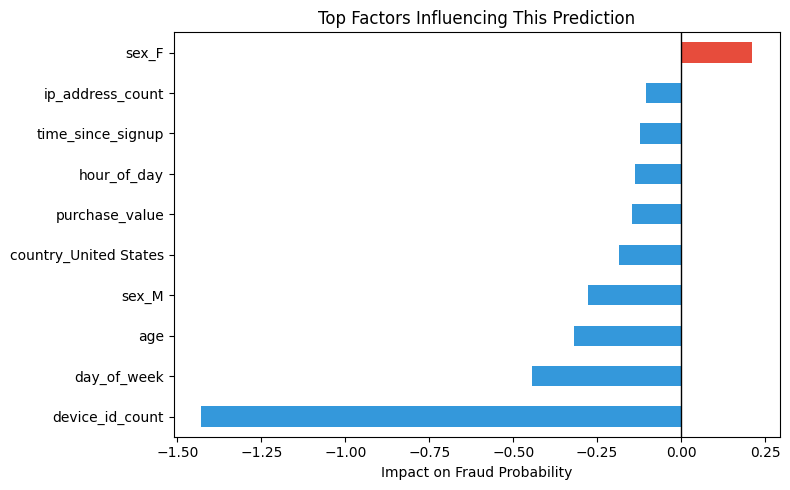

In [20]:
tp = cases["false_positive"]

viz.plot_single_prediction_bar(
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    top_n=10,
)

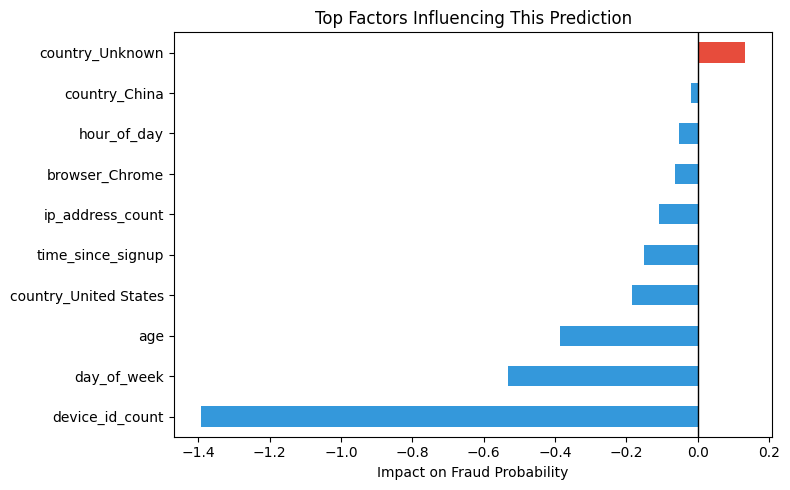

In [21]:
tp = cases["false_negative"]

viz.plot_single_prediction_bar(
    shap_values=shap_values,
    X=X_test,
    index=tp.name,
    top_n=10,
)

## Interpretation

### Built-in vs SHAP Importance
- Built-in importance emphasizes split frequency and gain
- SHAP captures **true contribution magnitude and direction**
- SHAP revealed stronger influence from:
  - Transaction velocity
  - Device reuse
  - Signup-to-purchase time

### Top 5 Fraud Drivers (SHAP)
1. time_since_signup
2. tx_count_user_id_1h
3. device_id_count
4. ip_address_count
5. hour_of_day

### Surprising Findings
- High transaction velocity outweighed transaction amount
- Legitimate users with shared devices triggered false positives
- Some fraud cases had normal amounts but abnormal timing patterns


## Interpretation

### Built-in vs SHAP Importance
- Built-in importance emphasizes split frequency and gain
- SHAP captures **true contribution magnitude and direction**
- SHAP revealed stronger influence from:
  - Transaction velocity
  - Device reuse
  - Signup-to-purchase time

### Top 5 Fraud Drivers (SHAP)
1. time_since_signup
2. tx_count_user_id_1h
3. device_id_count
4. ip_address_count
5. hour_of_day

### Surprising Findings
- High transaction velocity outweighed transaction amount
- Legitimate users with shared devices triggered false positives
- Some fraud cases had normal amounts but abnormal timing patterns
